<div align="right" style="text-align: right"><i>Peter Norvig, Oct 2017<br>Revised Jan 2020</i></div>

# Bicycling: Speed, Grade, VAM,  Hill-index, Eddington

Like most people, I bike slower when I'm going up a steep hill than on a flat road. But how much slower?
To answer that, I downloaded a bunch of my recorded [Strava](https://www.strava.com/athletes/575579) rides longer than 25 miles as [`bikerides25.tsv`](bikerides25.tsv).  I parse the file into `rides`, a list
of `Ride` structures. 

In [1]:
import matplotlib.pyplot as plt
import collections
import numpy as np
import re

In [2]:
Ride = collections.namedtuple('Ride', 'miles, hours, feet, date, title')

def parse_rides(lines: str) -> [Ride]:
    """Parse lines from a Strava log file into a list of `Ride`. Tab separated fields:
    Ride	Thu, 8/9/2018	BRNW	4:58:07	68.41 mi	3,862 ft"""
    return [Ride(number(mi), parse_hours(time), number(ft), date, title)
            for line in lines if line.startswith('Ride')
            for _, date, title, time, mi, ft in [line.strip().split('\t')]]

def number(string) -> float: return float(re.sub(r'[^0-9. ]', '', string))

def parse_hours(time: str) -> float: 
    if time.count(':') < 2: time = '0:' + time
    hour, min, sec = map(int, time.split(':'))
    return hour + min/60 + sec/3600

rides = parse_rides(open('bikerides25.tsv'))

From the raw data I will derive three important arrays of numbers: 
- `miles`: array of lengths of each ride in miles
- `hours`: array of durations of each ride in hours
- `feet`: array of total climbing of each ride in feet 

I'll show a simple scatter plot  visualization:

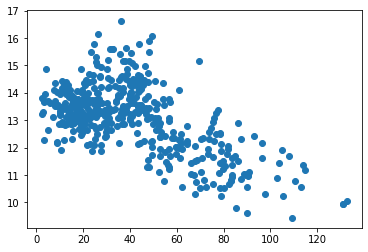

In [3]:
def column(attr, rides): return np.array([getattr(r, attr) for r in rides])

miles = column('miles', rides)
hours = column('hours', rides)
feet  = column('feet',  rides)

plt.scatter(feet/miles, miles/hours);

# Making it Prettier

As expected, there is a lot of variance, but overall speeds get slower as the grade gets steeper. Just eyeballing the scatter plot, it looks like some kind of downward sloping curve would be a better fit than a straight line, so I'll fit quadratic (degree two) and cubic (degree 3) polynomials to the data (for no good theoretical reason; just because those are two simple nonlinear functions and numpy has a solver for them). I'll also make the plot prettier and bigger:

In [4]:
def show(X, Y, xlabel='Grade (feet/mile)', ylabel='Speed (mph)', degrees=(2, 3)): 
    """Plot X versus Y and a best fit curve to it, with some bells and whistles."""
    plt.rcParams["figure.figsize"] = (12, 10)
    plt.style.use('fivethirtyeight')
    grid(); plt.ylabel(ylabel); plt.xlabel(xlabel)
    plt.scatter(X, Y, c='k')
    X1 = np.linspace(min(X), max(X), 100)
    for degree in degrees:
        F = poly_fit(X, Y, degree)
        plt.plot(X1, [F(x) for x in X1], '-', lw=2)
    plt.title(f'{len(X)} rides')

def grid(): plt.minorticks_on(); plt.grid(which='minor', ls=':', alpha=0.7)
    
def poly_fit(X, Y, degree) -> callable:
    """The polynomial function that best fits the X,Y vectors."""
    coeffs = np.polyfit(X, Y, degree)[::-1]
    return lambda x: sum(c * x ** i for i, c in enumerate(coeffs))         

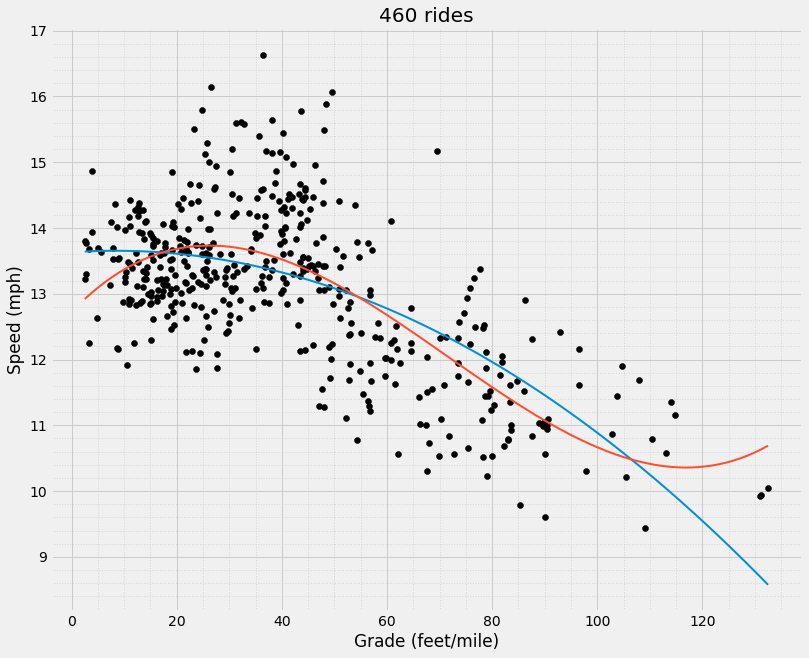

In [5]:
show(feet/miles, miles/hours)

So, I average a little under 14 mph when the overall route is fairly flat, with a lot of variability from 12 to 16 mph, depending more on my level of effort than on the grade of the road. But when the grade is steeper than 50 ft/mile, the speed falls off quickly: down to 12mph at 80 ft/mile;  11 mph at 100 ft/mile; and around 10 mph at 120 ft/mile. Note that 120 ft/mile is only 2.3% grade, but if you figure a typical route is 1/3 up, 1/3 down, and 1/3 flat, then that's 6.9% average grade on the up part.

# Estimating Time of a Ride

This data can help me predict how long will it take to ride a route with a given distance and elevation. For example, to get to  Pescadero from La Honda, I could take the flatter [coast route](https://www.google.com/maps/dir/La+Honda,+California/Pescadero,+California/@37.2905834,-122.3896683,12z/data=!4m19!4m18!1m10!1m1!1s0x808faed4dc6265bd:0x51a109d3306a7219!2m2!1d-122.274227!2d37.3190255!3m4!1m2!1d-122.4039496!2d37.3116594!3s0x808f062b7d7585e7:0x942480c22f110b74!1m5!1m1!1s0x808f00b4b613c4c1:0x43c609077878b77!2m2!1d-122.3830152!2d37.2551636!3e1) (15.7 miles, 344 ft climb), or the shorter [creek route](https://www.google.com/maps/dir/La+Honda,+California/Pescadero,+California/@37.2905834,-122.3896683,12z/data=!4m19!4m18!1m10!1m1!1s0x808faed4dc6265bd:0x51a109d3306a7219!2m2!1d-122.274227!2d37.3190255!3m4!1m2!1d-122.3658887!2d37.2538867!3s0x808f00acf265bd43:0xb7e2a0c9ee355c3a!1m5!1m1!1s0x808f00b4b613c4c1:0x43c609077878b77!2m2!1d-122.3830152!2d37.2551636!3e1) (13.5 miles, 735 ft climb); which is faster?

In [6]:
def estimate(dist, climb, F=poly_fit(feet/miles, miles/hours, 2)) -> float:
    """Given a distance in miles and total climb in feet, estimate time in minutes."""
    return 60 * dist / F(climb / dist)

In [7]:
f'Coast: {estimate(15.7, 344):.0f} min, Creek: {estimate(13.5, 735):.0f} min.'

'Coast: 69 min, Creek: 63 min.'

This predicts the shorter creek route would be about 6 minutes faster. Good to know, but other factors (like the scenery) are probably more important in making the choice.

# Segments

The data I have so far helps me estimate the duration for a long ride over varying up-and-down terrain. But what if I just want to know how long it will take to climb the next hill? To answer that I'll go back to Strava and retrieve data from individual **segments**, some only a fraction of a mile long, some several miles long, but most with a relatively constant grade. I picked some representative climbing segments ([`bikesegments.csv`](bikesegments.csv)) with the segment length in miles and climb in feet, along with several of my times on the segment. (Strava shows my times for up to 10 rides on each segment; I picked the first, middle, and last of the rides shown.) 

In [8]:
def parse_segments(lines):
    """Parse a string of segments into Rides. Each line contains:
    'title, miles, feet, time(s)'."""
    for segment in lines:
        title, mi, ft, *times = segment.split(',')
        for time in times:
            time = parse_hours(time)
            yield Ride(float(mi), time, int(ft), 'date?', title)
            
segments = list(parse_segments(open('bikesegments.csv')))

miles2 = column('miles', segments)
hours2 = column('hours', segments)
feet2  = column('feet',  segments) 

For the plot I will list grade in percent rather than feet per mile:

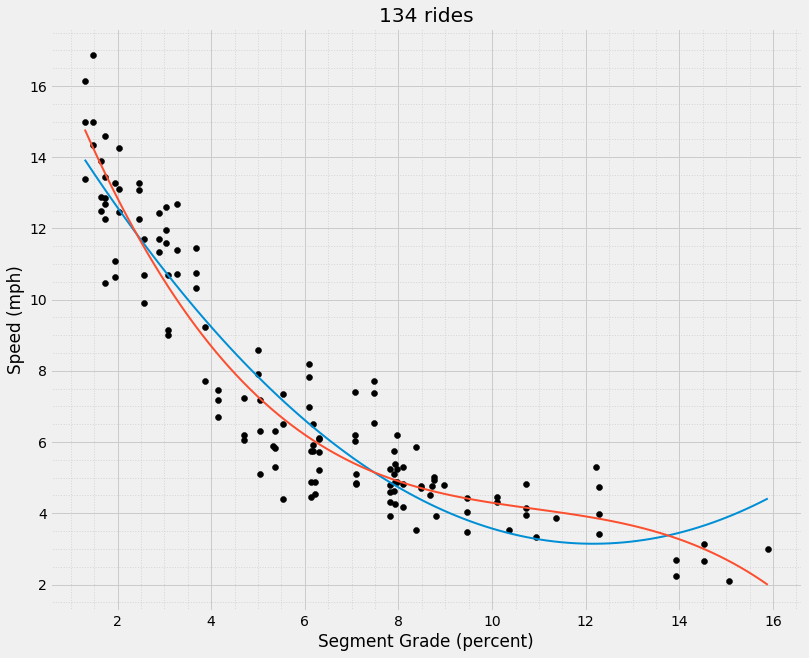

In [9]:
pct2 = feet2 / miles2 * 100 / 5280

show(pct2, miles2 / hours2, xlabel='Segment Grade (percent)')  

So I can cruise at 15 to 17 mph on a 1% grade, but only about 8 mph at 5% grade, and around 5 mph on 8% grades.

# VAM

The average number of vertical feet (or meters) climbed per hour (regardless of horizontal distance travelled) is known as [VAM](https://en.wikipedia.org/wiki/VAM_%28bicycling%29), which stands for *velocità ascensionale media* (for native Campagnolo speakers) or *mean ascent velocity* (for SRAM) or 平均上昇率 (for Shimano). The theory is that for medium-steepish climbs, most of your power is going into lifting against gravity, so your VAM should be about constant no matter what the grade in that range. (For flatish rides power is spent on wind and rolling resistance, and for super-steep rides power goes largely to cursing *sotto voce*, as they say in Italian.) Here's a plot of my VAM versus grade (in percent):

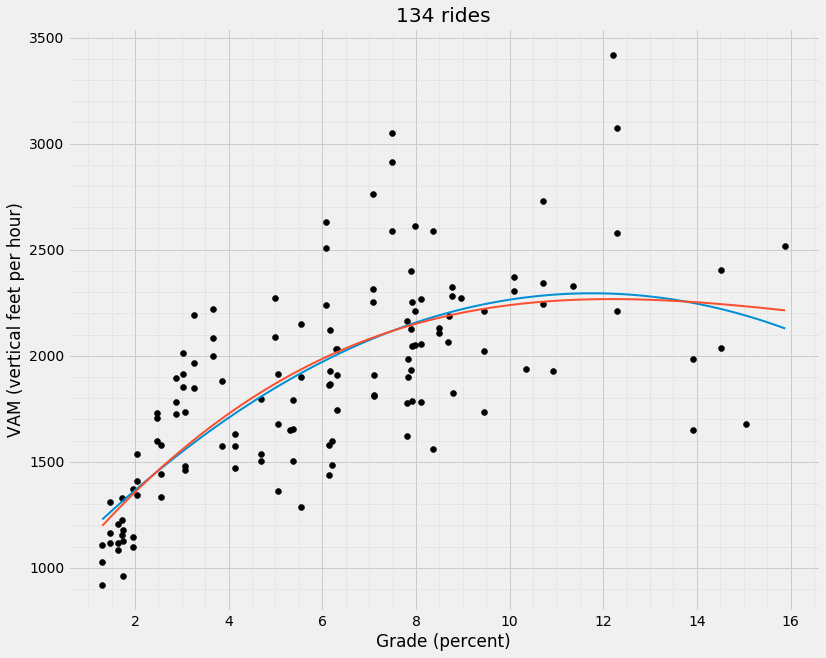

In [10]:
show(pct2, feet2 / hours2, xlabel='Grade (percent)', 
     ylabel='VAM (vertical feet per hour)')

I don't see the flattening effect; I see a wide spread of VAM numbers; at about 8% I range from 1500 to 3000 VAM. Champions can do  6000. 

Another way to look at it: at what speed am I getting the most VAM (implicitly assuming I'm giving a similar level of effort at all times, which is not really true)? The curve says 5 or 6 mph, but the data is pretty noisy.



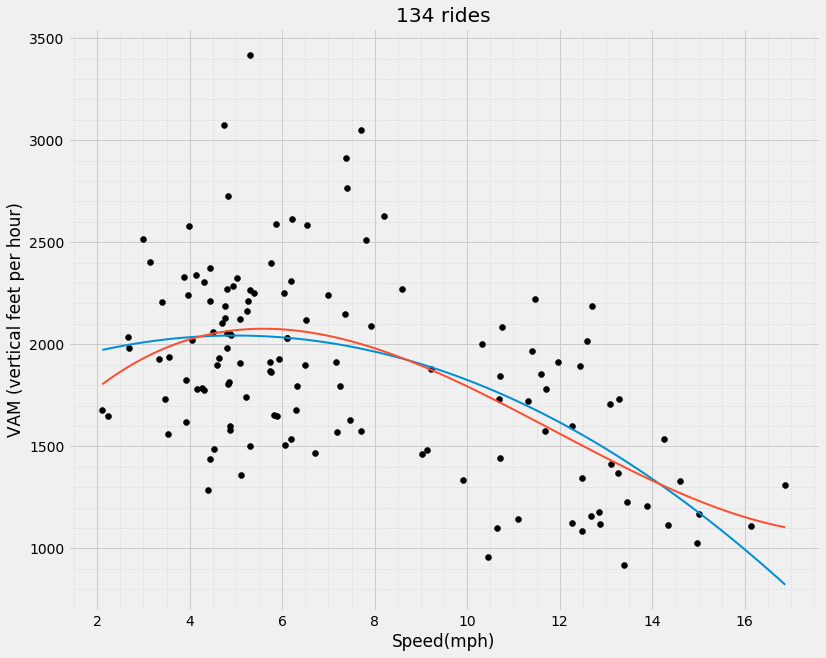

In [11]:
show(miles2 / hours2, feet2 / hours2, xlabel='Speed(mph)', 
     ylabel='VAM (vertical feet per hour)')

# Hill-Index

Inspired by the [h-index](https://en.wikipedia.org/wiki/H-index) for scientific publications, I invented a new metric, the hill-index:

> *Your **hill-index** is the maximum number**&nbsp;h** for which you can regularly climb an**&nbsp;h** percent grade at **&nbsp;h** miles per hour.*

I think **my hill-index is 6**. (I know that [Old La Honda](https://graphics.stanford.edu/~lucasp/grade/oldlahonda.html) is a 7% grade, and I only [achieved 7.0 mph](https://www.strava.com/segments/9343401?filter=my_results&gender=all) on it once out of many tries). But let's draw a plot to confirm:

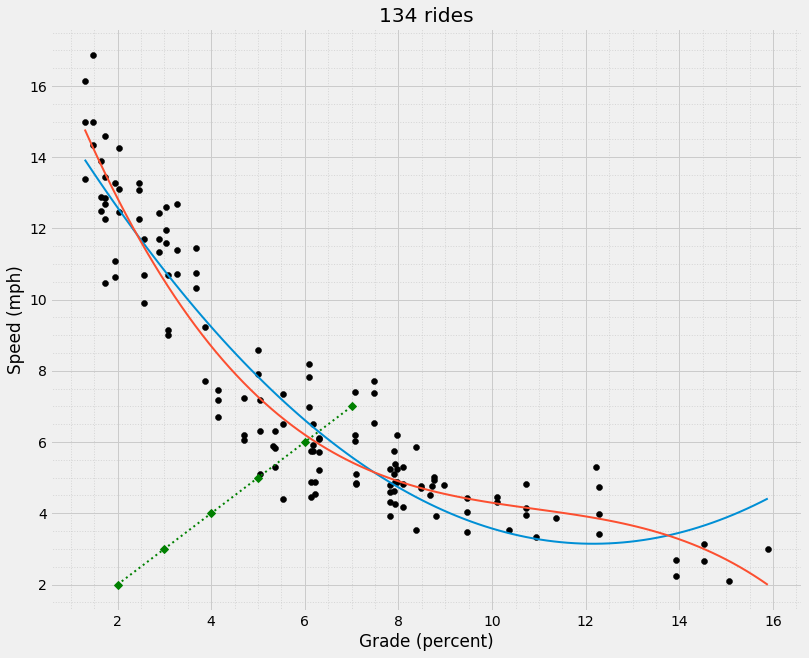

In [12]:
points = range(2, 8)
show(pct2, miles2 / hours2, xlabel='Grade (percent)')  
plt.plot(points, points, 'gD:', lw=2);

The  green dotted line is where grade = speed, the red and blue lines are best-fit polynomials, and  both best-fit lines are above the diamond at 6%, but both are below the diamond for 7%, so my guess is confirmed: my hill-index is 6.

Note that the original h-index for publications is based on cumulative totals, so it can never decrease, but the Hill-index is based on an average so it can (and sadly, often does) decrease as you grow older.



# Eddington Number

Speaking of h-numbers, the  physicist [Sir Arthur Eddington](https://en.wikipedia.org/wiki/Arthur_Eddington) (1882-1944) was a pre-Strava bicyclist who favored this metric:

> *Your [Eddington Number](https://www.triathlete.com/2011/04/training/measuring-bike-miles-eddington-number_301789) is the maximum integer **e** such that you have bicycled at least**&nbsp;e** miles on at least**&nbsp;e** days.*

Let's calculate mine:

In [13]:
def Eddington(distances) -> int:
    """Eddington number: The maximum integer e such that you have bicycled 
    a distance of at least e on at least e days."""
    distances = sorted(distances, reverse=True)
    return max(e for e, d in enumerate(distances, 1) if d >= e)

Eddington(miles)

58

My **Eddington Number is 58**: I've done at least 58 miles on at least 58 days. This is a bit above [the mean for Strava users](https://swinny.net/Cycling/-4687-Calculate-your-Eddington-Number), but not as good as Eddington himself: he was 62 years old when he died with a number of **84**, and his available roads, bicycles, and navigation aids were not nearly as nice as mine, so good for him.

How many rides would I need to improve my number from 58 to 60? It must be 2, right? **Wrong!** Here's the problem:

In [14]:
[r for r in rides if 58 <= r.miles <= 60]

[Ride(miles=59.11, hours=5.0325, feet=3528.0, date='Sat, 10/31/2015', title='Saratoga Ramble'),
 Ride(miles=58.81, hours=4.0633333333333335, feet=2467.0, date='Sat, 8/18/2018', title='Tour de Menlo'),
 Ride(miles=58.69, hours=5.2572222222222225, feet=6742.0, date='Sat, 4/26/2014', title='OLH / Tunitas Creek'),
 Ride(miles=58.42, hours=4.465, feet=4431.0, date='Sat, 6/15/2013', title='Palo Alto to Santa Cruz'),
 Ride(miles=58.29, hours=5.089722222222222, feet=6044.0, date='Sat, 10/11/2014', title='OLH / Tunitas'),
 Ride(miles=58.23, hours=3.8397222222222225, feet=4042.0, date='Sat, 7/9/2016', title='Santa Cruz')]

These six rides all counted towards my Eddington number of 58, but don't count towards an Eddington number of 60, because they are all less than 60 miles long. So I would need to replace all of these rides with 60+ mile rides before I get an Eddington number of 60. 

The following chart tells me how many rides I have to go&mdash;what I call the **Eddington Gap**&mdash;to reach various Eddington numbers:

In [15]:
def Egaps(distances, targets):
    """Print the number of days doing various target distances, and the Eddington gap."""
    print('Dist Days Gap')
    print('---- ---- ---')
    for target in targets:
        days = sum(d >= target for d in distances)
        print(f'{target:4} {days:4} {target - days:3}')
        
Egaps(miles, range(58, 71))

Dist Days Gap
---- ---- ---
  58   60  -2
  59   55   4
  60   54   6
  61   48  13
  62   46  16
  63   44  19
  64   42  22
  65   40  25
  66   38  28
  67   32  35
  68   30  38
  69   24  45
  70   23  47


An easy way to get bigger Eddington numbers is to use kilometers rather than miles:

In [16]:
kms = miles * 1.609344

Eddington(kms)

81

In [17]:
Egaps(kms, range(81, 101))

Dist Days Gap
---- ---- ---
  81   87  -6
  82   79   3
  83   78   5
  84   73  11
  85   72  13
  86   71  15
  87   69  18
  88   68  20
  89   67  22
  90   66  24
  91   64  27
  92   63  29
  93   60  33
  94   58  36
  95   55  40
  96   54  42
  97   51  46
  98   48  50
  99   46  53
 100   46  54


My **metric Eddington Number is 81**.

Here is my Eddington number progress over the years, in miles and kms, from when I first started tracking rides:

In [18]:
def year(ride) -> int: return int(ride.date[-4:])

def Eprogress(years, rides=rides):
    "Print a table of Eddington numbers by year"
    print('Year  E_ml  E_km')
    print('---- ----- -----')
    for y in years:
        miles = np.array([r.miles for r in rides if year(r) <= y])
        kms   = 1.609344 * miles
        print(f'{y} {Eddington(miles):5} {Eddington(kms):5}')
              
Eprogress(range(2014, 2021))

Year  E_ml  E_km
---- ----- -----
2014    34    45
2015    41    60
2016    46    65
2017    50    72
2018    53    75
2019    54    78
2020    58    81


*Note:* the definition of Eddington Number seems to be mathematically precise, but there is an ambiguity: what exactly does the word ***day*** mean? The New Oxford dictionary mentions (a) "a period of 24 hours"; (b) "a unit of time, reckoned from one midnight to the next"; and (c) "the part of a day when it is light".  I originally assumed ***day*** meant "one midnight to the next," but I wanted to make an exception for bikepacking trips where I rode to a camping site in the afternoon, spent the night there, and rode back home the next morning; what bikepackers call a [sub 24 hour overnight (S24O)](https://oneofsevenproject.com/s24o-bikepacking-guide/). I thought that should count as a valid trip. And then COVID struck, the camping sites closed, and I further relaxed the definition to allow an S24O ride where I sleep in my own home, as long as the riding is in a 24 hour window. I realize Eddington had a lot more hardships than we have (the 1918 pandemic, World War I, and World War II), but I hope he would approve of this accomodation on my part.